# Data source

In [1]:
## For data
import pandas as pd
import numpy as np
## For plotting
import matplotlib.pyplot as plt
## For parametric fitting
from scipy import optimize

In [2]:
dtf = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", sep=",")
dtf.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,16509,17267,18054,18969,19551,20342,20917,21459,22142,22890
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,1164,1184,1197,1212,1232,1246,1263,1299,1341,1385
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,9626,9733,9831,9935,10050,10154,10265,10382,10484,10589
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,844,851,852,852,852,852,852,852,852,852
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,86,86,86,86,88,91,92,96,113,118


In [3]:
## groupby country
dtf = dtf.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T

## convert index to datetime
dtf.index = pd.to_datetime(dtf.index, infer_datetime_format=True)

## create total cases column
dtf = pd.DataFrame(index=dtf.index, data=dtf["Indonesia"].values, columns=["total"])

## create daily changes column
dtf["new"] = dtf["total"] - dtf["total"].shift(1)
dtf["new"] = dtf["new"].fillna(method='bfill')

In [4]:
dtf.head()

,total,new
2020-01-22,0,0.0
2020-01-23,0,0.0
2020-01-24,0,0.0
2020-01-25,0,0.0
2020-01-26,0,0.0


In [5]:
dtf.tail()

,total,new
2020-06-07,31186,672.0
2020-06-08,32033,847.0
2020-06-09,33076,1043.0
2020-06-10,34316,1240.0
2020-06-11,35295,979.0


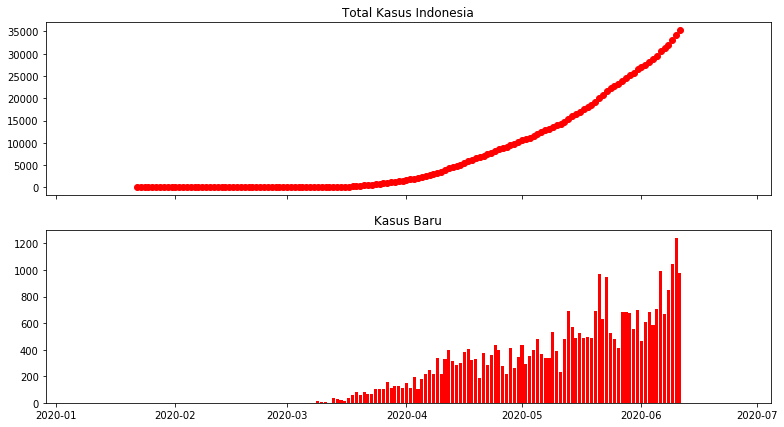

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(13,7))
ax[0].scatter(dtf.index, dtf["total"].values, color="red")
ax[0].set(title="Total Kasus Indonesia")
ax[1].bar(dtf.index, dtf["new"].values, color="red")
ax[1].set(title="Kasus Baru")
plt.show()

# Designing Model

In [7]:
#pakai tiga model : linear, Exponential, logistic

In [33]:
'''
Linear function: f(x) = a + b*x
'''
def f(x):
    return 10 + 150*x

y_linear = f(x=np.arange(len(dtf)))

'''
Exponential function: f(x) = a + b^x
'''
def f(x):
    return 1000 + 1.18**x

y_exponential = f(x=np.arange(len(dtf)))

'''
Logistic function: f(x) = a / (1 + e^(-b*(x-c)))
'''
def f(x): 
    return 90000 / (1 + np.exp(-0.5*(x-20)))

y_logistic = f(x=np.arange(len(dtf)))

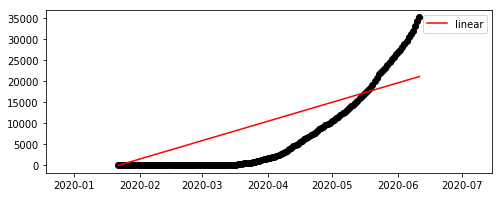

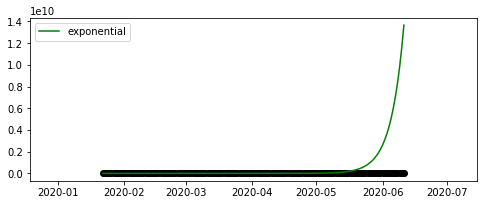

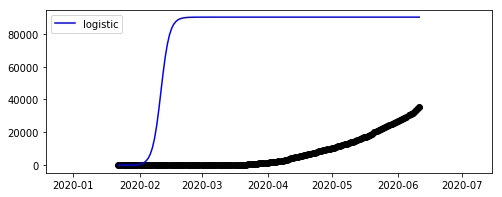

In [34]:
fig, ax = plt.subplots(figsize=(8,3))
fig, ay = plt.subplots(figsize=(8,3))
fig, az = plt.subplots(figsize=(8,3))

ax.scatter(dtf["total"].index, dtf["total"].values, color="black")
ax.plot(dtf["total"].index, y_linear, label="linear", color="red")
ay.scatter(dtf["total"].index, dtf["total"].values, color="black")
ay.plot(dtf["total"].index, y_exponential, label="exponential", color="green")
az.scatter(dtf["total"].index, dtf["total"].values, color="black")
az.plot(dtf["total"].index, y_logistic, label="logistic", color="blue")
ax.legend()
ay.legend()
az.legend()
plt.show()

# The new cases time series

In [10]:
'''
Gaussian function: f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def f(x):
    return 1000 * np.exp(-0.5 * ((x-60)/6)**2)

y_gaussian = f(x=np.arange(len(dtf)))

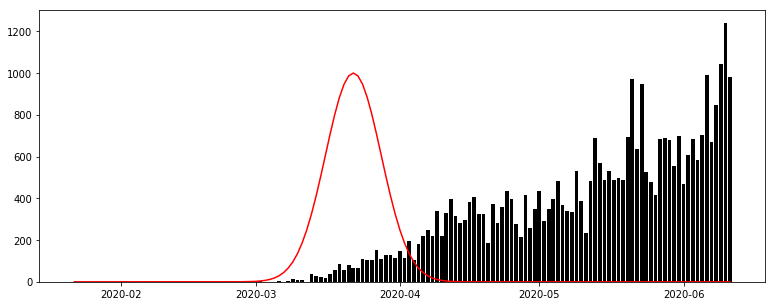

In [11]:
fig, ax = plt.subplots(figsize=(13,5))
ax.bar(dtf["new"].index, dtf["new"].values, color="black")
ax.plot(dtf["new"].index, y_gaussian, color="red")
plt.show()

In [12]:
'''
Logistic function: f(x) = capacity / (1 + e^-k*(x - midpoint) )
'''
def logistic_f(X, c, k, m):
    y = c / (1 + np.exp(-k*(X-m)))
    return y
a=np.arange(len(dtf["total"]))
b=dtf["total"].values
# ## optimize from scipy
logistic_model, cov = optimize.curve_fit(logistic_f,
                                np.arange(len(dtf["total"])), 
                                dtf["total"].values, 
                                maxfev=10000,
                                p0=[np.max(dtf["total"]), 1, 1])
## print the parameters
logistic_model

array([4.86423556e+04, 5.30955933e-02, 1.26049114e+02])

In [13]:
'''
Gaussian function: f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def gaussian_f(X, a, b, c):
    y = a * np.exp(-0.5 * ((X-b)/c)**2)
    return y
## optimize from scipy
gaussian_model, cov = optimize.curve_fit(gaussian_f,
                                np.arange(len(dtf["total"])), 
                                dtf["new"].values, 
                                maxfev=10000,
                                p0=[1, np.mean(dtf["new"]), 1])
## print the parameters
gaussian_model

D:\APLIKASI\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


array([  1.        , 248.55633803,   1.        ])

In [14]:
'''
Plot parametric fitting.
'''
def utils_plot_parametric(dtf, zoom=30, figsize=(15,5)):
    ## interval
    dtf["residuals"] = dtf["ts"] - dtf["model"]
    dtf["conf_int_low"] = dtf["forecast"] - 1.96*dtf["residuals"].std()
    dtf["conf_int_up"] = dtf["forecast"] + 1.96*dtf["residuals"].std()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    ## entire series
    dtf["ts"].plot(marker=".", linestyle='None', ax=ax[0], title="Parametric Fitting", color="black")
    dtf["model"].plot(ax=ax[0], color="green")
    dtf["forecast"].plot(ax=ax[0], grid=True, color="red")
    ax[0].fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3)
   
    ## focus on last
    first_idx = dtf[pd.notnull(dtf["forecast"])].index[0]
    first_loc = dtf.index.tolist().index(first_idx)
    zoom_idx = dtf.index[first_loc-zoom]
    dtf.loc[zoom_idx:]["ts"].plot(marker=".", linestyle='None', ax=ax[1], color="black", 
                                  title="Zoom on the last "+str(zoom)+" observations")
    dtf.loc[zoom_idx:]["model"].plot(ax=ax[1], color="green")
    dtf.loc[zoom_idx:]["forecast"].plot(ax=ax[1], grid=True, color="red")
    ax[1].fill_between(x=dtf.loc[zoom_idx:].index, y1=dtf.loc[zoom_idx:]['conf_int_low'], 
                       y2=dtf.loc[zoom_idx:]['conf_int_up'], color='b', alpha=0.3)
    plt.show()
    return dtf[["ts","model","residuals","conf_int_low","forecast","conf_int_up"]]

In [21]:
'''
Forecast unknown future.
:parameter
    :param ts: pandas series
    :param f: function
    :param model: list of optim params
    :param pred_ahead: number of observations to forecast (ex. pred_ahead=30)
    :param freq: None or str - 'B' business day, 'D' daily, 'W' weekly, 'M' monthly, 'A' annual, 'Q' quarterly
    :param zoom: for plotting
'''
def forecast_curve(ts, f, model, pred_ahead=None, freq="M", zoom=30, figsize=(20,5)):
    ## fit
    X = np.arange(len(ts))
    fitted = f(X, model[0], model[1], model[2])
    dtf = ts.to_frame(name="ts")
    dtf["model"] = fitted
    
    ## index
    index = pd.date_range(start="20200601",periods=30,freq="D")
    index = index[1:]
    ## forecast
    Xnew = np.arange(len(ts)+1, len(ts)+1+len(index))
    preds = f(Xnew, model[0], model[1], model[2])
    dtf = dtf.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))
    
    ## plot
    utils_plot_parametric(dtf, zoom=zoom)
    return dtf

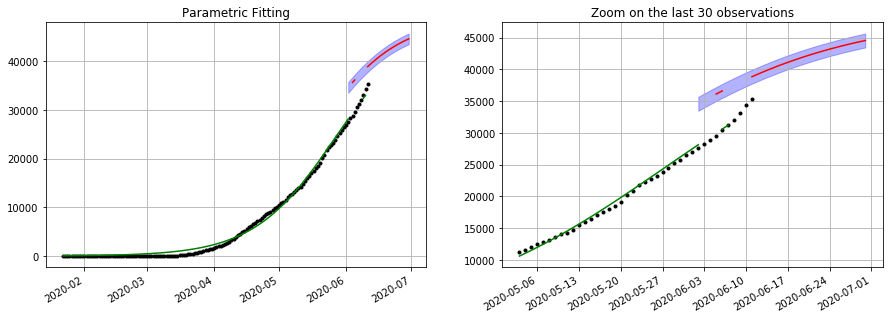

In [27]:
preds = forecast_curve(dtf["total"], logistic_f, logistic_model, 
                       pred_ahead=30, freq="M", zoom=30)

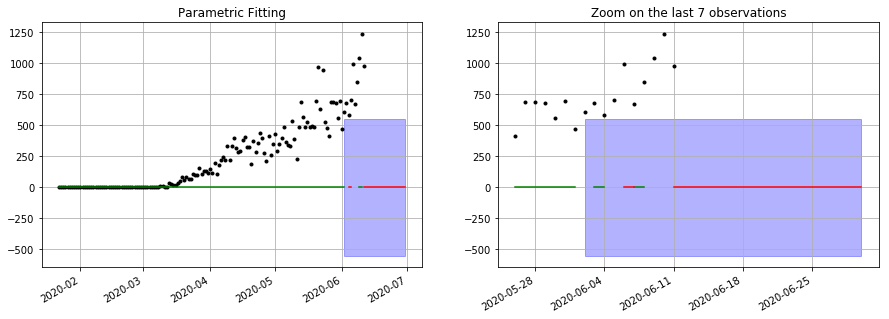

In [23]:
preds = forecast_curve(dtf["new"], gaussian_f, gaussian_model, 
                       pred_ahead=5, freq="d", zoom=7)